In [1]:
# Import packages 

# Add .. to access parent directory
import sys
sys.path.append("../")

# Standard Imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Transformers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# Modeling Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report
from IPython.display import display, Markdown

# Pipelines
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

**For this exercise, we will use an [income classification dataset](https://www.kaggle.com/lodetomasi1995/income-classification/data).**

Our data is seperated into two files:
- Training Data
    - 29,305 rows
- Validation Data
    - 3,256 rows
    
    
**Outline**
1. Transform data
2. Fit a model
3. Create a pipeline
4. Predict on unseen data
5. Save pipeline

In [2]:
# Import data
df = pd.read_csv('../data/training.csv')
# Reform column names
df.columns = [x.strip().replace(' ', '_').replace('-', '_') for x in df.columns]

df.head(2)

,Unnamed:_0,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


## Some basic cleaning

As is common with csv files, pandas is reading in the ```index``` of the dataset as a column called ```Unnamed_0```. 

Let's drop this column because it has no relationship without target variable.

In [3]:
df = df.iloc[:,1:]
df.head(2)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


In [4]:
target_labeler = LabelEncoder()
df.income = target_labeler.fit_transform(df.income)

# EDA

EDA can be found in the [EDA Notebook](./EDA.ipynb).

# Modeling

In [5]:
def model_report(name, scores):

    template = '''### {}\n\n|        	|    	|
|---------------	|----	|
| Minimum Score 	| {} 	|
| Average Score 	| {} 	|
| Maximum Score 	| {} 	|'''.format(name, scores.min(), scores.mean(), scores.max())
    
    display(Markdown(template))

def evaluation(y, y_hat, title = 'Confusion Matrix'):
    '''takes in true values and predicted values.
    The function then prints out a classifcation report
    as well as a confusion matrix using seaborn's heatmap.'''
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat, average = 'weighted')
    recall = recall_score(y, y_hat, average = 'weighted')
    accuracy = accuracy_score(y,y_hat)
    print(classification_report(y, y_hat))
    print('Accurancy: ', accuracy)
    sns.heatmap(cm,  cmap= 'Greens', annot=True)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title(title)
    plt.show()

## Baseline

**We will drop the following features.**

- Income
    - This is our target column and should not be included as a predictor
- fnlwgt
    - This feature represents weights assigned by the Census Search Results Bureau. 
- race & sex
    - If the point of our modeling were to statistical tests to examine the relationship between race and sex, including these features would likely be fine. Using them for purely predictive purpose, in my, is not appropriate.
    
    
And we will convert the ```education_num``` to string so it will be considered categorical.

In [6]:
dropped_columns = ['income', 'fnlwgt', 'race', 'sex']
df.education_num = df.education_num.astype(str)

Let's create a baseline Decision Tree model on our numerical columns.

Let's start by creating two arrays for categorical and numerical features.

In [7]:
categorical_columns = df.drop(dropped_columns, axis = 1)\
                        .select_dtypes('object')\
                        .columns

numerical_columns = df.drop(dropped_columns, axis = 1)\
                      .select_dtypes('number')\
                      .columns

In [8]:
def first_split():
    return train_test_split(df[numerical_columns], df.income, random_state=2020) 

In [9]:
X_train, X_test, y_train, y_test = first_split()

Based on our EDA, we will bin the `age`, `capital_gain`, and `capital_loss` columns

We will apply a Standard Scaler to the ```hours_per_week``` columns.

In [10]:
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [11]:
def bin_middle_age(age):
    if age < 45:
        return 0 
    elif age > 64:
        return 0
    else: 
        return 1
    
def bin_capital(x):
    if x > 0:
        return 1
    else:
        return 0
    
# Scale Data
hours_scaler = StandardScaler()
X_train.hours_per_week = hours_scaler.fit_transform(X_train['hours_per_week'].values.reshape(-1,1))

# Bin Data
X_train.age = X_train.age.apply(bin_middle_age)
X_train.capital_gain = X_train.capital_gain.apply(bin_capital)
X_train.capital_loss = X_train.capital_loss.apply(bin_capital)

In [12]:
baseline_model = DecisionTreeClassifier()
baseline_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

              precision    recall  f1-score   support

           0       0.80      0.97      0.88     16681
           1       0.72      0.24      0.36      5297

    accuracy                           0.79     21978
   macro avg       0.76      0.61      0.62     21978
weighted avg       0.78      0.79      0.75     21978

Accurancy:  0.7945672945672946


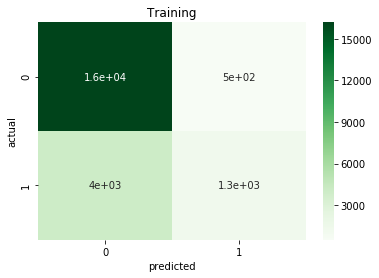

              precision    recall  f1-score   support

           0       0.77      0.97      0.86      5546
           1       0.48      0.09      0.15      1781

    accuracy                           0.76      7327
   macro avg       0.63      0.53      0.50      7327
weighted avg       0.70      0.76      0.69      7327

Accurancy:  0.7554251398935444


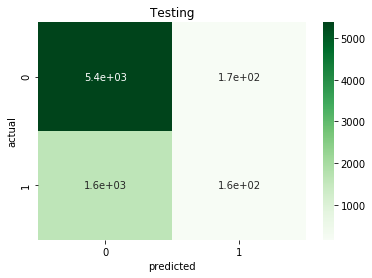

In [13]:
# Make Predictions
train_preds = baseline_model.predict(X_train)
test_preds = baseline_model.predict(X_test)

# Evaluation Predictions
evaluation(y_train, train_preds, title = 'Training')
evaluation(y_test, test_preds, title='Testing')

These models aren't doing too poorly, but...

# What did we do wrong?

If we take a look at ```X_train```...

In [14]:
X_train.head(2)

,age,capital_gain,capital_loss,hours_per_week
10626,0,0,1,-0.035176
5205,0,0,0,-1.663803


...and ```X_test```.

In [15]:
X_test.head(2)

,age,capital_gain,capital_loss,hours_per_week
28190,43,0,0,40
25450,44,0,0,60


*We did not transform the testing data!*

What are our ways of fixing this?

We could do something like this...

![](../images/code_block.png)

A level up would be to compile this code into a function...

In [16]:
def clean(df):
    X = df.copy()
    X.hours_per_week = hours_scaler.transform(X.hours_per_week.values.reshape(-1,1))
    X.age = X.age.apply(bin_middle_age)
    X.capital_gain = X.capital_gain.apply(bin_capital)
    X.capital_loss = X.capital_loss.apply(bin_capital)
    
    return X

But what if we wanted to apply these steps while using cross validation?

We can't! In order to use cross validation, our transformers have to be refit on new data. This function only transforms data. 

We need something that can differentiate between training and testing data, and use fit or transform appropriately.

# Introducing ```sklearn.pipeline.Pipeline()``` object.

![](https://raw.githubusercontent.com/learn-co-students/pickles-and-pipelines-seattle-ds-012720/4817cebf95395b6f10ad882bf9daac528a0650dc/visuals/transformer.gif)

### Definition of a pipeline
From the docs:
>The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. [The Pipeline object] sequentially applies a list of transforms and a final estimator. Intermediate steps of the pipeline must be ‘transforms’ (i.e. transformers), that is, they must implement fit and transform methods.

### Broad generalization of a pipeline
The key here is we need to specify a specific column, pass it's "transformer" (i.e. SimpleImputer, OneHotEncoder, StandardScaler), and determine if the transformation belongs in it's own new column or if it's more appropriate for the transformed column to overwrite the input column.

Benefits of the Pipeline
From the User Guide:

>- **Convenience and encapsulation**
    - You only have to call fit and predict once on your data to fit a whole sequence of estimators.
- **Joint parameter selection**
     - You can grid search over parameters of all estimators in the pipeline at once.
- **Safety**
    - Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

Here, we'll create a few Pipeline objects to do the following:
- Scale ```hours_per_week```.
- Bin Age Column
- Bin Capital Gain & Capital Loss Columns

### Create custom transformer for binning data.
In this case, we can't rely on importing a traditional transformer (i.e. StandardScaler, OneHotEncoder, etc.).

Instead, we'll need to create our own custom transformer. We will do this by creating a new class that implements both .fit() and .transform() methods.

In [17]:
class _BinAge(BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def _bin_data(self, x):
        if x < 45 or x > 64:
            return 0 
        else: 
            return 1
    
    def transform(self, X):
        if type(X) == dict:
            X = pd.DataFrame([X], index = len([X]))
        data = X.copy()
        data['age'] = data['age'].apply(self._bin_data)
        
        return data 

class _BinCapital(BaseEstimator):
    def __init__(self, col_name):
        self.col_name = col_name
    
    def fit(self, X, y=None):
        return self
    
    def _bin_data(self, x):
        if x > 0:
            return 1
        else:
            return 0
    
    def transform(self, X):
        if type(X) == dict:
            X = pd.DataFrame([X], index = len([X]))
        data = X.copy()
        data[self.col_name] = data[self.col_name].apply(self._bin_data)
        
        return data      

## Create first pipeline

In [18]:
binning_steps = [
    ('bin_capital_gain', _BinCapital(col_name = 'capital_gain')),
    ('bin_capital_loss', _BinCapital(col_name = 'capital_loss')),
    ('bin_age', _BinAge())]

data_binner = Pipeline(steps=binning_steps)

In [19]:
standard_scaler = ColumnTransformer(transformers=[
    ("s_scale", StandardScaler(), ['hours_per_week'])
],
                      remainder="passthrough")

In [20]:
X_train, X_test, y_train, y_test = first_split()

In [21]:
first_pipeline = Pipeline(steps= [('binner', data_binner),('standard_scaler', standard_scaler)])

first_pipeline.fit(X_train)

Pipeline(memory=None,
         steps=[('binner',
                 Pipeline(memory=None,
                          steps=[('bin_capital_gain',
                                  _BinCapital(col_name='capital_gain')),
                                 ('bin_capital_loss',
                                  _BinCapital(col_name='capital_loss')),
                                 ('bin_age', _BinAge())],
                          verbose=False)),
                ('standard_scaler',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('s_scale',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                               

In [22]:
# Repeat our steps from above to prove
# the results are the same

hours_scaler = StandardScaler()
X_train_copy = X_train.copy()
X_train_copy.hours_per_week = hours_scaler.fit_transform(X_train_copy['hours_per_week'].values.reshape(-1,1))
X_train_copy.age = X_train_copy.age.apply(bin_middle_age)
X_train_copy.capital_gain = X_train_copy.capital_gain.apply(bin_capital)
X_train_copy.capital_loss = X_train_copy.capital_loss.apply(bin_capital)

X_train_copy.head(2)

,age,capital_gain,capital_loss,hours_per_week
10626,0,0,1,-0.035176
5205,0,0,0,-1.663803


In [23]:
pipeline_output = first_pipeline.transform(X_train)
pipeline_output

array([[-0.03517649,  0.        ,  0.        ,  1.        ],
       [-1.66380276,  0.        ,  0.        ,  0.        ],
       [ 4.76927101,  0.        ,  0.        ,  0.        ],
       ...,
       [ 0.77913665,  1.        ,  0.        ,  0.        ],
       [ 0.61627402,  0.        ,  0.        ,  0.        ],
       [-0.03517649,  0.        ,  0.        ,  0.        ]])

Value wise, the results with a pipeline are mostly the same. Sklearn transformer objects convert integers to floats, which for machine learning is typically ideal. 

A difference between these two that is certainly not trivial is the loss of column names.

Sklearn transformers convert dataframes to lists. 
>To pass dataframe objects between transformers in a pipeline, more customization is required. 

**Benefit of pipelines**

If we wanted to experiment with different scales of our data, we can easily swap out scalers.

In [24]:
standard_scaler = ColumnTransformer(transformers=[
    ("s_scale", StandardScaler(), ['hours_per_week'])
],
                      remainder="passthrough")

min_max_scaler = ColumnTransformer(transformers=[
    ('min_max', MinMaxScaler(), ['hours_per_week'])
], remainder='passthrough')

ss_prep = Pipeline([
    ('binner', data_binner),
    ('s_scaler', standard_scaler)
])

mm_prep = Pipeline([
    ('binner', data_binner),
    ('m_scaler', min_max_scaler)
])

In [25]:
X_train, X_test, y_train, y_test = first_split()

In [26]:
ss_prep.fit_transform(X_train)

array([[-0.03517649,  0.        ,  0.        ,  1.        ],
       [-1.66380276,  0.        ,  0.        ,  0.        ],
       [ 4.76927101,  0.        ,  0.        ,  0.        ],
       ...,
       [ 0.77913665,  1.        ,  0.        ,  0.        ],
       [ 0.61627402,  0.        ,  0.        ,  0.        ],
       [-0.03517649,  0.        ,  0.        ,  0.        ]])

In [27]:
mm_prep.fit_transform(X_train)

array([[0.39795918, 0.        , 0.        , 1.        ],
       [0.19387755, 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       ...,
       [0.5       , 1.        , 0.        , 0.        ],
       [0.47959184, 0.        , 0.        , 0.        ],
       [0.39795918, 0.        , 0.        , 0.        ]])

## Add a model to our pipeline

In [28]:
model = DecisionTreeClassifier(random_state=2020)

first_full_pipeline = Pipeline([('preprocessing', ss_prep),
                                ('model', model)])

              precision    recall  f1-score   support

           0       0.80      0.97      0.88     16681
           1       0.72      0.24      0.36      5297

    accuracy                           0.79     21978
   macro avg       0.76      0.61      0.62     21978
weighted avg       0.78      0.79      0.75     21978

Accurancy:  0.7945672945672946


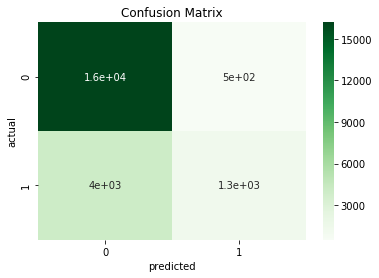

In [29]:
first_full_pipeline.fit(X_train, y_train)

train_preds = first_full_pipeline.predict(X_train)

evaluation(y_train, train_preds)

**Use cross validation!**

In [30]:
X = df.drop(dropped_columns, axis = 1)
y = df.income

cv = KFold(n_splits=5, shuffle=True, random_state=2020)

scores = cross_val_score(first_full_pipeline, X[numerical_columns], y, cv=cv, n_jobs=-1)

model_report('First Pipeline', scores)

### First Pipeline

|        	|    	|
|---------------	|----	|
| Minimum Score 	| 0.7834840470909401 	|
| Average Score 	| 0.7867258147073877 	|
| Maximum Score 	| 0.7920150145026446 	|

## Ok so what if we want to add categorical columns to our Pipeline?

>For this dataset, this is where it get's a bit tricky.

In [31]:
binner = Pipeline(steps=[
('bin_capital_gain', _BinCapital(col_name = 'capital_gain')),
     ('bin_capital_loss', _BinCapital(col_name = 'capital_loss'))
])

encoder = ColumnTransformer(transformers=[
    ('hot_encode', OneHotEncoder(drop='first'), categorical_columns)
], remainder='passthrough')


data_prep = Pipeline([('bin', binner),
                      ('encode', encoder)])

model = DecisionTreeClassifier()

pipeline = Pipeline(steps=[('prep', data_prep), ('model', model)])

In [32]:
try:
    scores = cross_val_score(pipeline, X, y, cv=cv, n_jobs=-1)
    model_report('Decision Tree', scores)
except:
    print("Found unknown categories [' Holand-Netherlands'] in column 6 during transform")


Found unknown categories [' Holand-Netherlands'] in column 6 during transform


### What happened?

If we take a look at our full data:

In [33]:
df[df.native_country == ' Holand-Netherlands']

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
17657,32,Private,27882,Some-college,10,Never-married,Machine-op-inspct,Other-relative,White,Female,0,2205,40,Holand-Netherlands,0


There is a single row with Holand-Netherlands as the native_country

During cross validation, we are creating training splits that do not contain this observation, and the OneHotEncoder is not factoring it into the feature mappings. 

Certainly, we could drop this row. And in this case if would probably make the most sense, but what if we had 100-300 observations for 'Holand-Netherlands'? In a large dataset, we could run into the same problem.

In these instances, it makes the most sense to leave the OneHotEncoder out the pipeline, and only add it back once a final model has been selected.

In [34]:
categorical_encoder = OneHotEncoder(drop='first')

hot_encoded = categorical_encoder.fit_transform(X[categorical_columns])

hot_encoded = pd.DataFrame(hot_encoded.todense(), 
                           columns=categorical_encoder.get_feature_names(),
                           index=X.index)

X_encoded = pd.concat([X.drop(categorical_columns, axis = 1), hot_encoded], axis = 1)

In [35]:
model = DecisionTreeClassifier()

pipeline = Pipeline(steps=[('bin', binner), ('model', model)])

scores = cross_val_score(pipeline, X_encoded, y, cv=cv, n_jobs=-1)

model_report('Decision Tree - With Categoricals', scores)

### Decision Tree - With Categoricals

|        	|    	|
|---------------	|----	|
| Minimum Score 	| 0.7845077631803447 	|
| Average Score 	| 0.7922538815901723 	|
| Maximum Score 	| 0.7998635045214127 	|

In [36]:
model = RandomForestClassifier()

pipeline = Pipeline(steps=[('prep',binner), ('model', model)])

scores = cross_val_score(pipeline, X_encoded, y, cv=cv, n_jobs=-1)

model_report('Random Forest', scores)

### Random Forest

|        	|    	|
|---------------	|----	|
| Minimum Score 	| 0.8182903941306944 	|
| Average Score 	| 0.8253540351475858 	|
| Maximum Score 	| 0.8314280839447193 	|

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     16685
           1       0.96      0.94      0.95      5293

    accuracy                           0.98     21978
   macro avg       0.97      0.96      0.97     21978
weighted avg       0.98      0.98      0.98     21978

Accurancy:  0.975975975975976


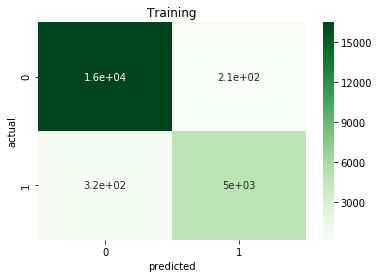

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      5542
           1       0.65      0.56      0.60      1785

    accuracy                           0.82      7327
   macro avg       0.76      0.73      0.74      7327
weighted avg       0.81      0.82      0.82      7327

Accurancy:  0.820936263136345


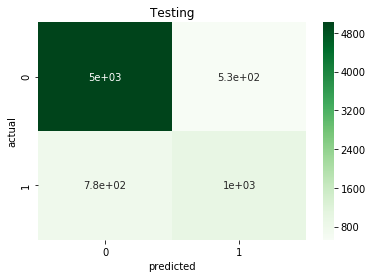

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y)
pipeline.fit(X_train, y_train)
train_preds = pipeline.predict(X_train)
test_preds = pipeline.predict(X_test)
evaluation(y_train, train_preds, title = 'Training')
evaluation(y_test, test_preds, title = 'Testing')

# Grid Search with Pipelines

In [38]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'prep', 'model', 'prep__memory', 'prep__steps', 'prep__verbose', 'prep__bin_capital_gain', 'prep__bin_capital_loss', 'prep__bin_capital_gain__col_name', 'prep__bin_capital_loss__col_name', 'model__bootstrap', 'model__ccp_alpha', 'model__class_weight', 'model__criterion', 'model__max_depth', 'model__max_features', 'model__max_leaf_nodes', 'model__max_samples', 'model__min_impurity_decrease', 'model__min_impurity_split', 'model__min_samples_leaf', 'model__min_samples_split', 'model__min_weight_fraction_leaf', 'model__n_estimators', 'model__n_jobs', 'model__oob_score', 'model__random_state', 'model__verbose', 'model__warm_start'])

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     22227
           1       0.77      0.52      0.62      7078

    accuracy                           0.85     29305
   macro avg       0.81      0.73      0.76     29305
weighted avg       0.84      0.85      0.83     29305

Accurancy:  0.8457601091963829


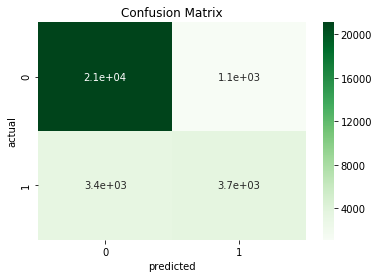

In [39]:
hyperparameters = {'model__max_depth': list(range(2,18,2)),
                    'model__max_leaf_nodes': [60, 80, 100]
                    
                  }
clf = GridSearchCV(pipeline, hyperparameters, cv=3)
 

clf.fit(X_encoded, y)

preds = clf.predict(X_encoded)
evaluation(y, preds)

In [40]:
final_model = clf.best_estimator_

In [41]:
Subset_1, Subset_2, true_1, true_2 = train_test_split(X_encoded, y, test_size=.5, random_state=2020)

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     11125
           1       0.78      0.51      0.62      3527

    accuracy                           0.85     14652
   macro avg       0.82      0.73      0.76     14652
weighted avg       0.84      0.85      0.84     14652

Accurancy:  0.8471198471198471


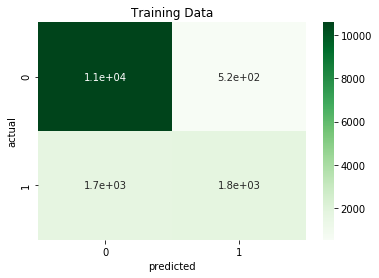

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     11102
           1       0.76      0.52      0.62      3551

    accuracy                           0.84     14653
   macro avg       0.81      0.74      0.76     14653
weighted avg       0.84      0.84      0.83     14653

Accurancy:  0.8444004640687913


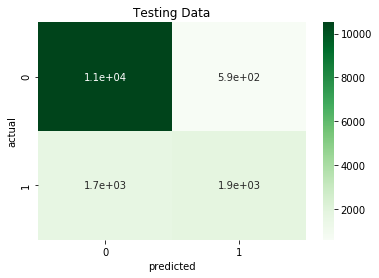

In [42]:
preds_1 = final_model.predict(Subset_1)
preds_2 = final_model.predict(Subset_2)

evaluation(true_1, preds_1, title = 'Training Data')
evaluation(true_2, preds_2, title = 'Testing Data')

# Final Pipeline

In [43]:
%load_ext autoreload
%autoreload 2

from src.pipeline import *

final_data_binner = Pipeline(steps=[
    ('bin_capital_gain', BinCapital(col_name = 'capital_gain')),
    ('bin_capital_loss', BinCapital(col_name = 'capital_loss')),
    ('bin_age', BinAge()),
    ('hot_encode', HotEncodeMerge())])


final_data_prep = Pipeline(steps=[
    ('validate_data', ValidateAndRenameColumns()),
    ("data_binning", final_data_binner)])

final_pipeline = Pipeline(steps=[('prep',final_data_prep), ('model', final_model)])

In [44]:
final_pipeline.fit(df, df.income)

Pipeline(memory=None,
         steps=[('prep',
                 Pipeline(memory=None,
                          steps=[('validate_data', ValidateAndRenameColumns()),
                                 ('data_binning',
                                  Pipeline(memory=None,
                                           steps=[('bin_capital_gain',
                                                   BinCapital(col_name='capital_gain')),
                                                  ('bin_capital_loss',
                                                   BinCapital(col_name='capital_loss')),
                                                  ('bin_age', BinAge()),
                                                  ('hot_encode',
                                                   <src.pipeline.HotEncodeMerge object at 0x1a22bf3a20...
                                                         ccp_alpha=0.0,
                                                         class_weight=None,
                

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      2493
           1       0.72      0.52      0.60       763

    accuracy                           0.84      3256
   macro avg       0.79      0.73      0.75      3256
weighted avg       0.83      0.84      0.83      3256

Accurancy:  0.8409090909090909


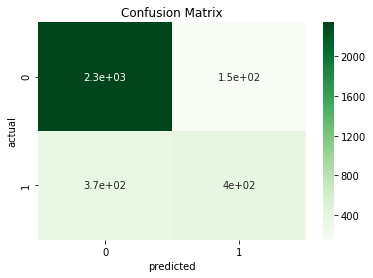

In [45]:
validation = pd.read_csv('../data/validation.csv')
validation_preds = final_pipeline.predict(validation)
validation_y = target_labeler.transform(validation.income)
evaluation(validation_y, validation_preds)

# Pickling

**Pickling** allows us to save python objects as binary files!

The pickle module was imported at the top of this notebook using

```import pickle```

With picklem, can save lists, dictionaries, and we can even save functions!

Here, we will look at saving models so they can be used outside out of a Jupyter Notebook!

In [46]:
with open('../models/RandomForestPipeline.pkl', 'wb') as file:
    pickle.dump(final_pipeline, file)

Now, we can import the pipeline and apply it to data!

In [47]:
with open('../models/RandomForestPipeline.pkl', 'rb') as file:
    imported_pipeline = pickle.load(file)

In [48]:
final_pipeline.predict(df)

array([0, 1, 0, ..., 0, 0, 1])